# What is torch.nn really?

In this notebook, I'll try to reproduce (from memory, as much as possible) the pytorch tutorial [What is torch.nn really?](https://docs.pytorch.org/tutorials/beginner/nn_tutorial.html)

The first step (which I will not reproduce from memory) is to download the MNIST dataset. Then I will train logistic regression without using any of the PyTorch modules `nn.Module`, `torch.optim`, `torch.Dataset`, and `torch.DataLoader`. I will then introduce these elements into my code one-by-one, showing how at each step the code gets simpler.

Finally, I will replace my logistic regression model with a CNN. I will then switch from CPU to GPU, writing code that trains the CNN on a GPU device.

In [46]:
import torch
from torch import nn
import torch.nn.functional as F

### Step 1: Load MNIST

In [ ]:
from pathlib import Path
import requests

In [48]:
DATA_PATH = Path("datasets")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [49]:
import pickle 
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_val, y_val), _) = pickle.load(f, encoding="latin-1")

(50000, 784)
0.99609375


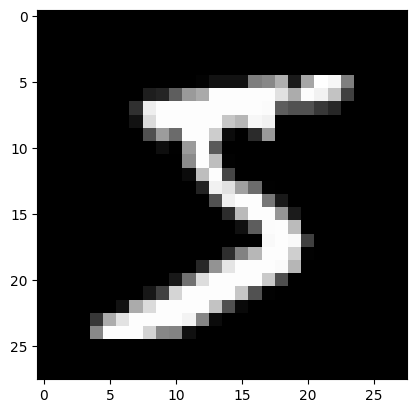

In [50]:
import matplotlib.pyplot as plt 
import numpy as np

plt.imshow(x_train[0].reshape(28, 28), cmap="gray")
print(x_train.shape)
print(x_train.max())

### Step 2: Convert numpy arrays to pytorch tensors

In [51]:
print(type(x_train), type(y_train))
x_train, x_val, y_train, y_val = map(
    torch.tensor, (x_train, x_val, y_train, y_val)
)
print(type(x_train), type(y_train))
print(x_train.dtype, y_train.dtype)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.float32 torch.int64
torch.Size([50000, 784]) torch.Size([50000])
torch.Size([10000, 784]) torch.Size([10000])


### Step 3: Neural network from scratch

Neural network training consists of loading data from batches, writing down a model, initializing parameters, writing down a loss function, computing the gradients of the loss function with respect to the parameters, and optimizing the parameters using an optimization algorithm. Let's implement each of these steps from scratch.

In [52]:
import math

In [53]:
lr = 1e-2
batch_size = 64
num_train = x_train.shape[0]


# used for testing
x_batch = x_train[0 : batch_size]
y_batch = y_train[0 : batch_size]

In [54]:
# parameter initialization: Xavier normal initialization
# weights drawn from normal distribution with mean 0, variance 2 / (n_in + n_out)
# multiplying normal distribution with variance 1 by sigma gives variance sigma**2

def init_params():
    sigma = math.sqrt((784 + 10) / 2)
    weight = torch.randn(784, 10) / sigma
    bias = torch.zeros(10, requires_grad=True)
    weight.requires_grad_()
    return weight, bias

def model(xb, weight, bias):
    return xb @ weight + bias

def loss_fn(logits, y):
    return -(logits[range(y.shape[0]), y] - logits.exp().sum(1).log()).mean(0)

def accuracy(logits, y):
    return sum([torch.argmax(logit) == idx for logit, idx in zip(logits, y)]) / y.shape[0] 

def test_model(x, y, weight, bias):
    with torch.no_grad():
        logits = model(x, weight, bias)
        print(loss_fn(logits, y))
        print(accuracy(logits, y))

In [55]:
# test that loss function works
test_model(x_batch, y_batch, *init_params())

tensor(2.3683)
tensor(0.1250)


In [56]:
weight, bias = init_params()
test_model(x_batch, y_batch, weight, bias)

num_epochs = 5
for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    for i in range((num_train - 1) // batch_size + 1):
        start_i = batch_size * i
        end_i = start_i + batch_size
        x_batch = x_train[start_i:end_i]
        y_batch = y_train[start_i:end_i]
        logits = model(x_batch, weight, bias)
        loss = loss_fn(logits, y_batch)
        
        loss.backward()
        with torch.no_grad():
            weight -= lr * weight.grad
            bias -= lr * bias.grad
            weight.grad.zero_()
            bias.grad.zero_()
    
    test_model(x_batch, y_batch, weight, bias)

tensor(2.3455)
tensor(0.0625)
Epoch: 0
tensor(1.0889)
tensor(0.6250)
Epoch: 1
tensor(0.9220)
tensor(0.7500)
Epoch: 2
tensor(0.8461)
tensor(0.7500)
Epoch: 3
tensor(0.7980)
tensor(0.8125)
Epoch: 4
tensor(0.7626)
tensor(0.8125)


### Step 4: Use ```torch.nn.Functional``` to rewrite loss function

In [57]:
import torch.nn.functional as F

In [58]:
loss_fn = F.cross_entropy 

In [59]:
weight, bias = init_params()
test_model(x_batch, y_batch, weight, bias)

num_epochs = 5
for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    for i in range((num_train - 1) // batch_size + 1):
        start_i = batch_size * i
        end_i = start_i + batch_size
        x_batch = x_train[start_i:end_i]
        y_batch = y_train[start_i:end_i]
        logits = model(x_batch, weight, bias)
        loss = loss_fn(logits, y_batch)
        
        loss.backward()
        with torch.no_grad():
            weight -= lr * weight.grad
            bias -= lr * bias.grad
            weight.grad.zero_()
            bias.grad.zero_()
    
    test_model(x_batch, y_batch, weight, bias)

tensor(2.6762)
tensor(0.)
Epoch: 0
tensor(1.1138)
tensor(0.6875)
Epoch: 1
tensor(0.9513)
tensor(0.7500)
Epoch: 2
tensor(0.8778)
tensor(0.7500)
Epoch: 3
tensor(0.8307)
tensor(0.8125)
Epoch: 4
tensor(0.7954)
tensor(0.8750)


### Step 5: Use ```nn.Module``` to keep track of parameters

In [60]:
class LogisticMnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(784, 10) * math.sqrt(2 / (784 + 10)))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, x):
        return x @ self.weight + self.bias

def test_model(x, y, model):
    with torch.no_grad():
        logits = model(x)
        print(loss_fn(logits, y))
        print(accuracy(logits, y))

In [61]:
model = LogisticMnist()
test_model(x_batch, y_batch, model)

num_epochs = 5
for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    for i in range((num_train - 1) // batch_size + 1):
        start_i = batch_size * i
        end_i = start_i + batch_size
        x_batch = x_train[start_i:end_i]
        y_batch = y_train[start_i:end_i]
        logits = model(x_batch)
        loss = loss_fn(logits, y_batch)
        
        loss.backward()
        with torch.no_grad():
            for p in model.parameters():
                p -= lr * p.grad
            model.zero_grad()
    
    test_model(x_batch, y_batch, model)

tensor(2.6254)
tensor(0.0625)
Epoch: 0
tensor(1.1606)
tensor(0.6875)
Epoch: 1
tensor(0.9959)
tensor(0.7500)
Epoch: 2
tensor(0.9219)
tensor(0.8125)
Epoch: 3
tensor(0.8739)
tensor(0.8125)
Epoch: 4
tensor(0.8375)
tensor(0.8750)


### Step 6: Use ```nn.Linear``` to not have to write down parameters explicitly

In [62]:
class LogisticMnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10)

    def forward(self, x):
        return self.linear(x)

In [63]:
model = LogisticMnist()
test_model(x_batch, y_batch, model)

num_epochs = 5
for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    for i in range((num_train - 1) // batch_size + 1):
        start_i = batch_size * i
        end_i = start_i + batch_size
        x_batch = x_train[start_i:end_i]
        y_batch = y_train[start_i:end_i]
        logits = model(x_batch)
        loss = loss_fn(logits, y_batch)
        
        loss.backward()
        with torch.no_grad():
            for p in model.parameters():
                p -= lr * p.grad
            model.zero_grad()
    
    test_model(x_batch, y_batch, model)

tensor(2.3104)
tensor(0.)
Epoch: 0
tensor(1.1112)
tensor(0.7500)
Epoch: 1
tensor(0.9659)
tensor(0.7500)
Epoch: 2
tensor(0.8978)
tensor(0.7500)
Epoch: 3
tensor(0.8527)
tensor(0.8750)
Epoch: 4
tensor(0.8180)
tensor(0.8750)


### Step 7: Use ```torch.optim``` to simplify optimization

In [64]:
from torch import optim

In [65]:
model = LogisticMnist()
opt = optim.SGD(model.parameters(), lr)
test_model(x_batch, y_batch, model)

num_epochs = 5
for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    for i in range((num_train - 1) // batch_size + 1):
        start_i = batch_size * i
        end_i = start_i + batch_size
        x_batch = x_train[start_i:end_i]
        y_batch = y_train[start_i:end_i]
        logits = model(x_batch)
        loss = loss_fn(logits, y_batch)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    test_model(x_batch, y_batch, model)

tensor(2.3840)
tensor(0.)
Epoch: 0
tensor(1.1341)
tensor(0.7500)
Epoch: 1
tensor(0.9803)
tensor(0.7500)
Epoch: 2
tensor(0.9077)
tensor(0.7500)
Epoch: 3
tensor(0.8599)
tensor(0.8750)
Epoch: 4
tensor(0.8234)
tensor(0.8750)


### Step 8: Use ```torch.utils.data.Dataset``` to simplify data access

We will use ```torch.utils.data.TensorDataset``` which creates a dataset from tensors.

In [66]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)
val_ds = TensorDataset(x_val, y_val)

In [67]:
model = LogisticMnist()
opt = optim.SGD(model.parameters(), lr)
test_model(x_batch, y_batch, model)

num_epochs = 5
for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    for i in range((num_train - 1) // batch_size + 1):
        x_batch, y_batch = train_ds[batch_size * i: batch_size * i + batch_size]
        logits = model(x_batch)
        loss = loss_fn(logits, y_batch)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    test_model(x_batch, y_batch, model)

tensor(2.2314)
tensor(0.1250)
Epoch: 0
tensor(1.0729)
tensor(0.7500)
Epoch: 1
tensor(0.9233)
tensor(0.7500)
Epoch: 2
tensor(0.8538)
tensor(0.8750)
Epoch: 3
tensor(0.8091)
tensor(0.8750)
Epoch: 4
tensor(0.7755)
tensor(0.8750)


### Step 9: Use ```torch.utils.data.DataLoader``` to simplify minibatching

In [68]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=2*batch_size)

In [69]:
model = LogisticMnist()
opt = optim.SGD(model.parameters(), lr)
test_model(x_batch, y_batch, model)

epochs = 5
for epoch in range(epochs):
    print(epoch)
    for x_batch, y_batch in train_dl:
        logits = model(x_batch)
        loss = loss_fn(logits, y_batch)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    test_model(x_batch, y_batch, model)

tensor(2.3463)
tensor(0.0625)
0
tensor(0.5680)
tensor(0.8750)
1
tensor(0.5444)
tensor(0.8750)
2
tensor(0.3321)
tensor(0.9375)
3
tensor(0.2173)
tensor(1.)
4
tensor(0.3622)
tensor(0.9375)


### Step 10: Add Model Validation 

Hint: don't forget ```model.eval()``` and ```with torch.no_grad():```

In [70]:
model = LogisticMnist()
opt = optim.SGD(model.parameters(), lr)

epochs = 5
for epoch in range(epochs):
    model.train()
    for x_batch, y_batch in train_dl:
        logits = model(x_batch)
        loss = loss_fn(logits, y_batch)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        total_val_loss = sum(loss_fn(model(xb), yb) for xb, yb in val_dl)

    print(f"Epoch: {epoch} Validation loss: {total_val_loss / len(val_dl)}")

Epoch: 0 Validation loss: 0.6305475831031799
Epoch: 1 Validation loss: 0.487580806016922
Epoch: 2 Validation loss: 0.4319365322589874
Epoch: 3 Validation loss: 0.40091782808303833
Epoch: 4 Validation loss: 0.38082873821258545


### Step 11: Add ```fit()``` and ```get_data()``` functions

In [71]:
def get_data(train_ds, val_ds, batch_size):
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True),
        DataLoader(val_ds, batch_size=2 * batch_size)
    )

def loss_batch(model, xb, yb, loss_fn, opt=None):
    logits = model(xb)
    loss = loss_fn(logits, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)
    

def loss_eval(model, val_dl, loss_fn):
    with torch.no_grad():
        losses, batch_sizes = zip(*[loss_batch(model, xb, yb, loss_fn) for xb, yb in val_dl])
        val_loss = np.sum(np.multiply(losses, batch_sizes)) / np.sum(batch_sizes)
    return val_loss


def fit(model, train_dl, val_dl, loss_fn, opt, epochs):
    model.eval()
    val_loss = loss_eval(model, val_dl, loss_fn)
    print(f"Initial validation loss: {val_loss}")
    
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, xb, yb, loss_fn, opt)

        model.eval()
        val_loss = loss_eval(model, val_dl, loss_fn)

        print(f"Epoch: {epoch} Validation loss: {val_loss}")

In [72]:
model = LogisticMnist()
loss_fn = F.cross_entropy
opt = optim.SGD(model.parameters(), lr=lr)
epochs = 5
batch_size = 64

In [73]:
def get_model():
    model = LogisticMnist()
    opt = optim.SGD(model.parameters(), lr=lr)
    return model, opt
    
model, opt = get_model()
train_dl, val_dl = get_data(train_ds, val_ds, batch_size)

In [74]:
fit(model, train_dl, val_dl, loss_fn, opt, epochs)

Initial validation loss: 2.314932233428955
Epoch: 0 Validation loss: 0.6304339765548707
Epoch: 1 Validation loss: 0.4891471167087555
Epoch: 2 Validation loss: 0.4341113529205322
Epoch: 3 Validation loss: 0.4030500258684158
Epoch: 4 Validation loss: 0.383065370631218


### Step 12: Switch to CNN

Hint: simply apply 3 convolutional layers, followed by three ReLU layers, followed by average pooling with a window size of 4. 

In [75]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x):
        x = x.reshape(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.avg_pool2d(x, 4)
        return x.reshape(-1, x.shape[1])

In [76]:
def get_model():
    model = Mnist_CNN()
    opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    return model, opt

model, opt = get_model()
train_dl, val_dl = get_data(train_ds, val_ds, batch_size)

In [77]:
fit(model, train_dl, val_dl, loss_fn, opt, epochs)

Initial validation loss: 2.302840826034546
Epoch: 0 Validation loss: 0.34306378083229067
Epoch: 1 Validation loss: 0.22303513985276222
Epoch: 2 Validation loss: 0.21057697334289552
Epoch: 3 Validation loss: 0.18647764985561371
Epoch: 4 Validation loss: 0.17975205611884593


### Step 13: Use ```nn.Sequential```

Hint: use Lambda module which initializes with function, that can be passed to ```nn.Sequential``` as module. 

In [78]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [79]:
def preprocess(x):
    return x.reshape(-1, 1, 28, 28)

def postprocess(x):
    return x.reshape(-1, x.shape[1])

def get_model():
    model = nn.Sequential(
        Lambda(preprocess), 
        nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.AvgPool2d(4),
        Lambda(postprocess),
    )                     
    opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    return model, opt

In [80]:
model, opt = get_model()
train_dl, val_dl = get_data(train_ds, val_ds, batch_size)

In [81]:
fit(model, train_dl, val_dl, loss_fn, opt, epochs)

Initial validation loss: 2.302801552581787
Epoch: 0 Validation loss: 0.3203518694639206
Epoch: 1 Validation loss: 0.2484895849943161
Epoch: 2 Validation loss: 0.20789666791558264
Epoch: 3 Validation loss: 0.20751883352398873
Epoch: 4 Validation loss: 0.15556487129330634


### Step 14: Use wrapped ```DataLoader```

Hint: create a class with the methods ```__iter__``` and ```__len__``` which yields the next batch and applies a function to the dataset. This function will be our preprocessing function for the CNN which converts the length-784 array into 28x28. 

Hint: replace ```nn.AvgPool2d``` with ```nn.AdaptiveAvgPool2d``` which takes one argument, ```output_size```.

In [82]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield self.func(*b)

def get_model():
    model = nn.Sequential( 
        nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d(1),
        Lambda(postprocess),
    )                     
    opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    return model, opt

def preprocess(x, y):
    return x.reshape(-1, 1, 28, 28), y

In [83]:
train_dl, val_dl = get_data(train_ds, val_ds, batch_size)
train_dl = WrappedDataLoader(train_dl, preprocess)
val_dl = WrappedDataLoader(val_dl, preprocess)
model, opt = get_model()

In [84]:
fit(model, train_dl, val_dl, loss_fn, opt, epochs)

Initial validation loss: 2.303780846786499
Epoch: 0 Validation loss: 0.3385274554491043
Epoch: 1 Validation loss: 0.3311109385251999
Epoch: 2 Validation loss: 0.2782747683763504
Epoch: 3 Validation loss: 0.22899432329833508
Epoch: 4 Validation loss: 0.18766014320254326


### Step 15: Run on GPU

hint: use ```.to(device)``` for both tensors and model.

In [85]:
# this code won't work in old version of torch, but might work in Colab
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [86]:
x = torch.ones(5)
x = x.to(device)
print(x)

tensor([1., 1., 1., 1., 1.], device='mps:0')


In [87]:
def preprocess(x, y):
    return x.reshape(-1, 1, 28, 28).to(device), y.to(device)

def get_model():
    model = nn.Sequential( 
        nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d(1),
        Lambda(postprocess),
    )                     
    opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    return model.to(device), opt

In [88]:
train_dl, val_dl = get_data(train_ds, val_ds, batch_size)
train_dl = WrappedDataLoader(train_dl, preprocess)
val_dl = WrappedDataLoader(val_dl, preprocess)
model, opt = get_model()

In [89]:
for X, y in train_dl:
    print(X.shape, X.type())
    print(y.shape, y.type())
    break

torch.Size([64, 1, 28, 28]) torch.mps.FloatTensor
torch.Size([64]) torch.mps.LongTensor


In [90]:
fit(model, train_dl, val_dl, loss_fn, opt, epochs)

Initial validation loss: 2.302761427307129
Epoch: 0 Validation loss: 0.3885533068656921
Epoch: 1 Validation loss: 0.2600893201589584
Epoch: 2 Validation loss: 0.22128414344787598
Epoch: 3 Validation loss: 0.21105054746866225
Epoch: 4 Validation loss: 0.1956888154923916
